## Moving Average##

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline

#### Input params ##################
stk_path = "data/etf_1698.csv"
test_size = 0.2                 #  テストサイズ
cv_size = 0.2                   #　バリデーションサイズ

Nmax = 21

fontsize = 14
ticklabelsize = 14
####################################

In [2]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    t日の値を t-1, t-2, ..., t-N日の値の平均とする
    Inputs
        df             :予測に使用するデータ
        target_col :予測する値
        N              :t日の値を t-1, t-2, ..., t-N日の値を用いて予測する
        pred_min   :予測値の最低値
        offset         :len(df)-offsetを用いて予測
    Outputs
        pred_list
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean()

    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    #  計算値がpred_minより小さい場合はpred_minを代入
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
   平均絶対パーセント誤差 (MAP Error) を求める
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# データ読み込み

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Dete列をdate型に変換
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# headを小文字に変換
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# month列を追加
df['month'] = df['date'].dt.month

# datetimeでソート
df.sort_values(by='date', inplace=True, ascending=True)


df.head()

,date,open,high,low,close,volume,trading_value,month
0,2015-01-05,1529,1529,1486,1498,9510,1498,1
1,2015-01-06,1451,1465,1451,1452,11550,1452,1
2,2015-01-07,1450,1460,1447,1450,4720,1450,1
3,2015-01-08,1469,1477,1468,1471,1330,1471,1
4,2015-01-09,1480,1481,1468,1472,2050,1472,1


Text(0, 0.5, 'JPY')

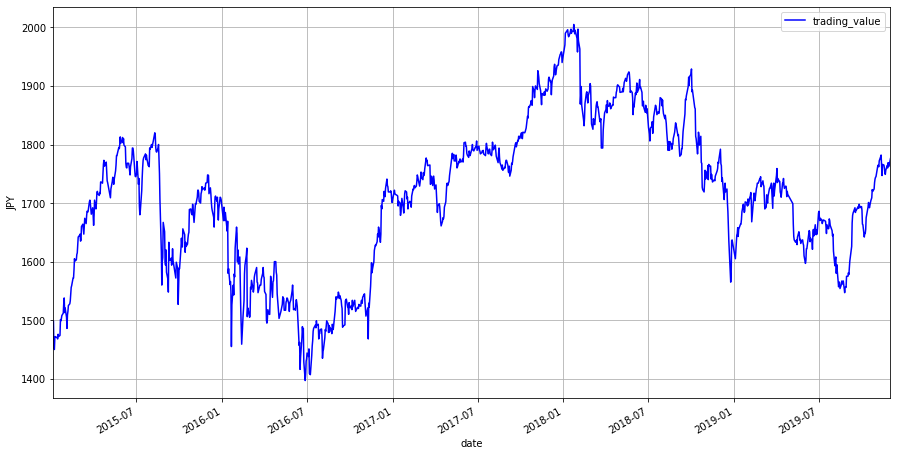

In [4]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = df.plot(x='date', y='trading_value', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("JPY")

# データをtrain,cv,testに分割 

In [5]:
# データセットのサイズ取得
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))


# train, cv, testに分割
train = df[:num_train][['date', 'trading_value']]
cv = df[num_train:num_train+num_cv][['date', 'trading_value']]
train_cv = df[:num_train+num_cv][['date', 'trading_value']]
test = df[num_train+num_cv:][['date', 'trading_value']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 720
num_cv = 239
num_test = 239
train.shape = (720, 2)
cv.shape = (239, 2)
train_cv.shape = (959, 2)
test.shape = (239, 2)


Text(0, 0.5, 'JPY')

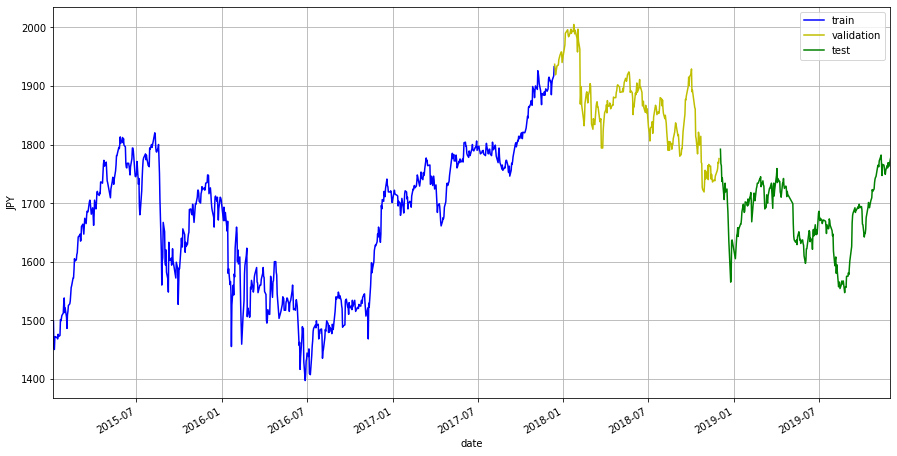

In [6]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

# 予測

In [7]:
RMSE = []
mape = []
for N in range(1, Nmax+1): 
    est_list = get_preds_mov_avg(train_cv, 'trading_value', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['trading_value'])))
    mape.append(get_mape(cv['trading_value'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [15.385016892089345, 17.242759683596944, 19.619544994536813, 21.60405877719591, 23.62617157441295, 25.574046329300046, 27.36705157505788, 29.017347781634605, 30.448836075763513, 31.707203885594797, 32.82007467127591, 33.87882287952849, 34.846308378302446, 35.79257617291628, 36.68069213179213, 37.552883953525956, 38.392132560445724, 39.25605775097967, 40.12187734041667, 40.9642779886294, 41.74828814220052]
MAPE = [0.593912418449241, 0.6808259301700541, 0.772772005752889, 0.8691118844877666, 0.9578928553417068, 1.0362686418797282, 1.1161898427020944, 1.1868202642551082, 1.2452791881795047, 1.2961123940007095, 1.3380614328982467, 1.3850891553414162, 1.427043333078911, 1.4657625374953769, 1.5041276400017183, 1.5385527819630245, 1.573352032750712, 1.610970031774138, 1.6524706601317811, 1.6954031189343663, 1.738181013668993]


,date,open,high,low,close,volume,trading_value,month
0,2015-01-05,1529,1529,1486,1498,9510,1498,1
1,2015-01-06,1451,1465,1451,1452,11550,1452,1
2,2015-01-07,1450,1460,1447,1450,4720,1450,1
3,2015-01-08,1469,1477,1468,1471,1330,1471,1
4,2015-01-09,1480,1481,1468,1472,2050,1472,1


# チューニング：N

([<matplotlib.axis.XTick at 0x1037906d0>,
 <a list of 5 Text xticklabel objects>)

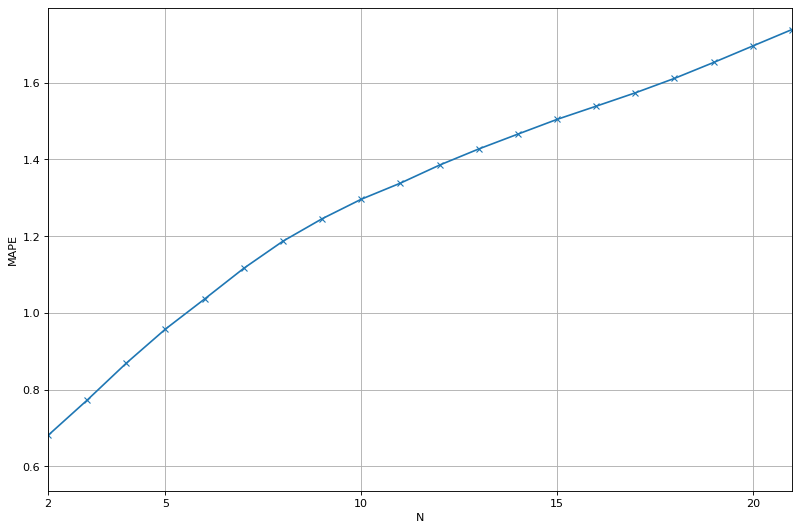

In [8]:
# MAPEをプロット
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [9]:
# 最適なNを決定
N_opt = 3

Text(0, 0.5, 'JPY')

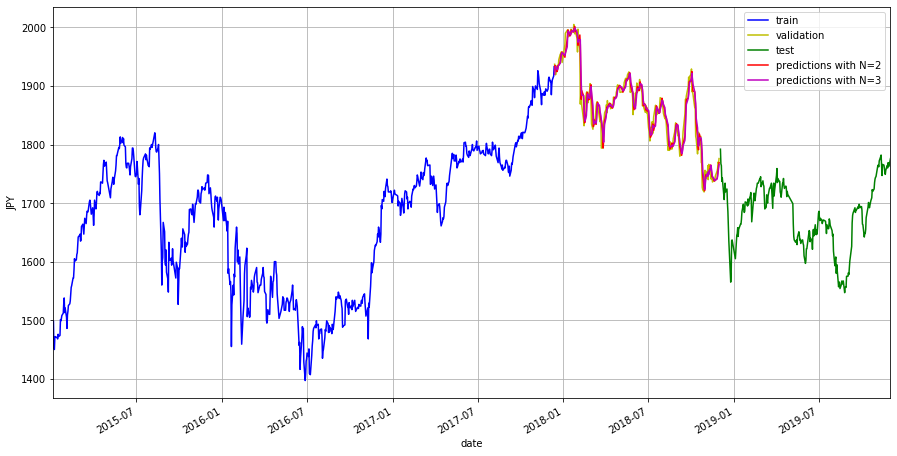

In [10]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N3', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=2', 'predictions with N=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

(1700, 2100)

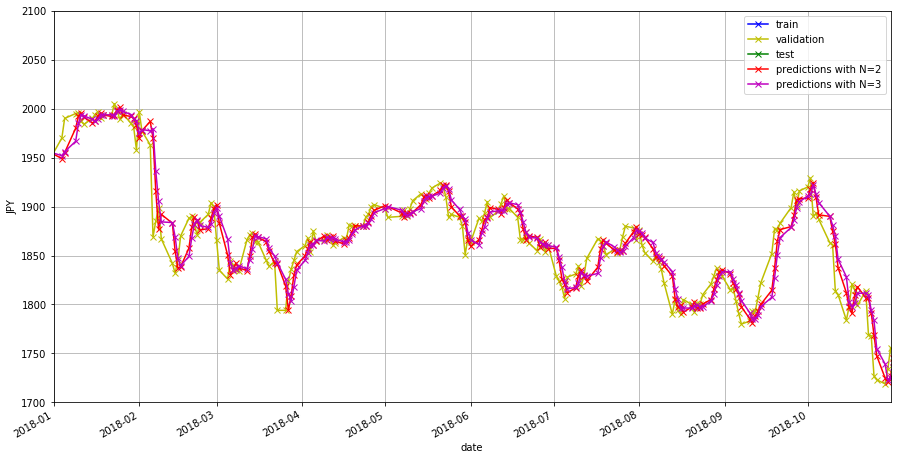

In [11]:
# trading_value(dev)をプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='bx-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N3', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=2', 'predictions with N=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2018, 1, 1), date(2018, 10, 31)])
ax.set_ylim([1700, 2100])

In [12]:
est_list = get_preds_mov_avg(df, 'trading_value', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['trading_value'])))
print("MAPE = %0.3f%%" % get_mape(test['trading_value'], est_list))
test.head()

RMSE = 18.150
MAPE = 0.787%


,date,trading_value,est_N3
959,2018-12-03,1792,1771.333333
960,2018-12-04,1767,1778.666667
961,2018-12-05,1764,1778.333333
962,2018-12-06,1737,1774.333333
963,2018-12-07,1743,1756.000000


In [ ]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N3', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

In [ ]:
# trading_value(test)をプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='bx-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N3', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2019, 3, 1), date(2019, 12, 2)])
ax.set_ylim([1500, 1800])

In [ ]:
# 結果を保存
test_mov_avg = test
test_mov_avg.to_csv("./out/test_mov_avg.csv")

In [ ]:
# trading_value(test)をプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='bx-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N3', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2019, 3, 1), date(2019, 12, 2)])
ax.set_ylim([1500, 1800])

In [ ]:
# 結果を保存
test_mov_avg = test
test_mov_avg.to_csv("./out/test_mov_avg.csv")

Text(0, 0.5, 'JPY')

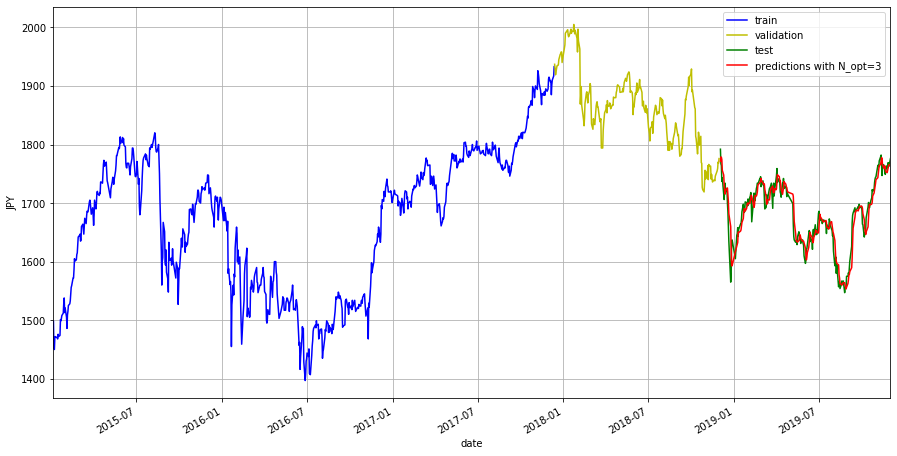

(1500, 1800)

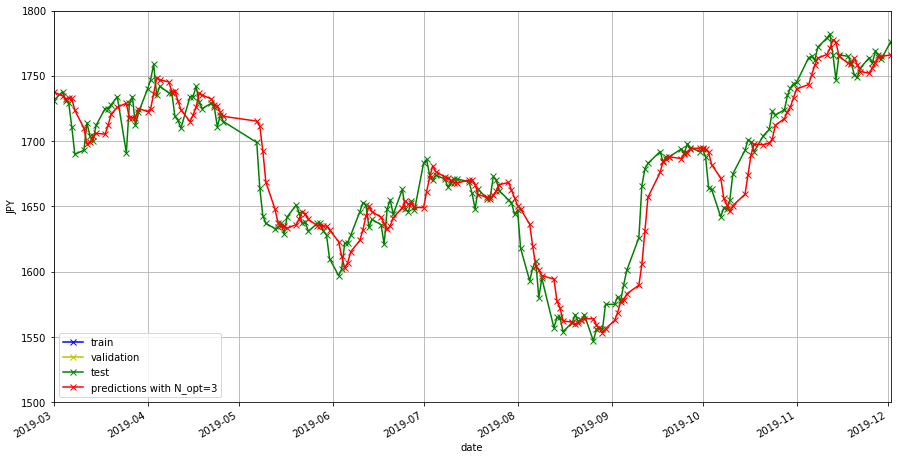

In [14]:
# trading_value(test)をプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='bx-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N3', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2019, 3, 1), date(2019, 12, 2)])
ax.set_ylim([1500, 1800])

In [15]:
# 結果を保存
test_mov_avg = test
test_mov_avg.to_csv("./out/test_mov_avg.csv")